# Getting data

In [ ]:
from google.colab import files
files.upload()

# Pipeline

In [1]:
import segmentation_models_pytorch as smp

In [2]:
import pandas as pd
def list_dict_mean(dictionary:dict):
    return pd.DataFrame(dictionary).median()

In [3]:
def plotter(train_logs, valid_logs, metrics):
    for param in metrics:
        tr_lst = [d[param] for d in train_logs]
        val_lst = [d[param] for d in valid_logs]
        
        plt.title(f'Plot for {param}')
        plt.plot(tr_lst,label = 'Train')
        plt.plot(val_lst,label = 'Validation')
        plt.legend()
        plt.show()

## DataSet

In [4]:
import os

from torch.utils import data
from PIL import Image
import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF

class simpleDataset(data.Dataset):
    
    # initialise function of class
    def __init__(self, root,transform,augmentations,preprocessing):
        # the data directory 
        self.root = root
        # the list of filename
        self.filenames = os.listdir(os.path.join(root,'images'))
        # transforms
        self.transform = transform
        #self.target_transform = target_transform
        self.augmentation = augmentations
        self.preprocessing = preprocessing

    # obtain the sample with the given index
    def __getitem__(self, index):
        # obtain filenames from list
        image_filename = self.filenames[index]
        # Load data and label
        image = cv2.imread(os.path.join(self.root,'images', image_filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        mask = cv2.imread(os.path.join(self.root,'masks', image_filename))
        
        
        if self.transform:
            #image,mask = self.transform([image,mask])
            tr = transform(image = np.array(image),mask=np.array(mask))
            '''
        if self.target_transform:
            mask = self.target_transform(mask)
            '''
            
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        # gettting 1 channel since they all the same    
        mask,_,__=cv2.split(image)
        
        '''
        # universal preprocessing
        image = TF.to_tensor(tr['image'])
        image = TF.normalize(image,(0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))
        mask = tr['mask']
        '''
        # output of Dataset must be tensor so tensor in transforms
        return image, mask
    
    # the total number of samples (optional)
    def __len__(self):
        return len(self.filenames)

In [5]:
import os

from torch.utils import data
from PIL import Image
import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF

class npyDataset(data.Dataset):
    
    # initialise function of class
    def __init__(self, root, augmentations = None,train_only_aug = None, preprocessing = None):
        # the data directory 
        self.root = root
        # the list of filename
        self.filenames = os.listdir(os.path.join(root,'images'))
        #self.target_transform = target_transform
        self.augmentation = augmentations
        self.train_only_aug = train_only_aug
        self.preprocessing = preprocessing

    # obtain the sample with the given index
    def __getitem__(self, index):
        # obtain filenames from list
        image_filename = self.filenames[index]
        # Load data and label
        image = cv2.imread(os.path.join(self.root,'images', image_filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        pre, ext = os.path.splitext(image_filename)
        mask_filename =  pre + '.npy'
        
        with open(os.path.join(self.root,'masks', mask_filename), 'rb') as f:
            mask = np.load(f)
        
        #made binary
        mask = (mask != 0).astype('float')
                   
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        
        if self.train_only_aug:
            sample = self.train_only_aug(image=image)
            image = sample['image']
            
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        image=image.float()
        '''
        # universal preprocessing
        image = TF.to_tensor(tr['image'])
        image = TF.normalize(image,(0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))
        mask = tr['mask']
        '''
        # output of Dataset must be tensor so tensor in transforms
        return image, mask
    
    # the total number of samples (optional)
    def __len__(self):
        return len(self.filenames)

In [6]:
import os

from torch.utils import data
from PIL import Image
import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF

class npyDatasetInMem(data.Dataset):
    
    # initialise function of class
    def __init__(self, root, augmentations = None,train_only_aug = None, preprocessing = None):
        # the data directory 
        self.root = root
        # the list of filename
        self.filenames = os.listdir(os.path.join(root,'images'))
        #self.target_transform = target_transform
        self.augmentation = augmentations
        self.train_only_aug = train_only_aug
        self.preprocessing = preprocessing
        
        self.images = []
        self.masks = []
        for image_filename in self.filenames:
            img = cv2.imread(os.path.join(self.root,'images', image_filename))
            self.images.append(img)
            
            pre, ext = os.path.splitext(image_filename)
            mask_filename =  pre + '.npy'
            
            with open(os.path.join(self.root,'masks', mask_filename), 'rb') as f:
                mask = np.load(f)
                
            mask = (mask != 0).astype('float')
            self.masks.append(mask)
        
        self.images = np.array(self.images,dtype=object)
        self.masks = np.array(self.masks,dtype=object)

    # obtain the sample with the given index
    def __getitem__(self, index):
        # obtain filenames from list
        image = self.images[index]
        mask = self.masks[index]
                   
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        
        if self.train_only_aug:
            sample = self.train_only_aug(image=image)
            image = sample['image']
            
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        image=image.float()
        '''
        # universal preprocessing
        image = TF.to_tensor(tr['image'])
        image = TF.normalize(image,(0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))
        mask = tr['mask']
        '''
        # output of Dataset must be tensor so tensor in transforms
        return image, mask
    
    # the total number of samples (optional)
    def __len__(self):
        return len(self.filenames)

Augmentation remainder
https://www.quantib.com/blog/image-augmentation-how-to-overcome-small-radiology-datasets

In [7]:
import albumentations as A
import cv2
import numpy as np
import matplotlib.pyplot as plt

import random


augmentations_seed = 24

random.seed(24)

transform = A.Compose([
    A.Resize(256,256),
    #A.RandomCrop(width=256, height=256),
    A.Rotate(p=0.6),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    #A.RandomBrightnessContrast(p=0.35),
    A.RandomResizedCrop(256,256,p=0.3)
])

In [8]:
train_transform = A.Compose([
    A.RandomBrightnessContrast(p=0.35)
])

https://towardsdatascience.com/creating-and-training-a-u-net-model-with-pytorch-for-2d-3d-semantic-segmentation-model-building-6ab09d6a0862

https://www.kaggle.com/balraj98/unet-with-pretrained-resnet50-encoder-pytorch

In [9]:
#https://github.com/qubvel/segmentation_models.pytorch/blob/master/examples/cars%20segmentation%20(camvid).ipynb

def to_tensor(x, **kwargs):
    return TF.to_tensor(x)
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
        A.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return A.Compose(_transform)

## Model

In [10]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=1, 
    activation=ACTIVATION,
)

In [11]:
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

### ----New super model

In [11]:
from multiresunet import MultiResUnet

def to_tensor(x, **kwargs):
    return TF.to_tensor(x)
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        #A.Lambda(image=preprocessing_fn),
        A.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return A.Compose(_transform)

model = MultiResUnet(channels=3,filters=16,nclasses=2)

## Initializing dataset

### Trying only top pictures

In [14]:
dataset_dir = r'E:\University\ScienceWork\Medicine\AortaStuff\ML\datasets\data_merged_npy_top'
dataset = npyDataset(dataset_dir, 
                     transform,train_transform,get_preprocessing(preprocessing_fn))
print(len(dataset))

62


### Trying only descending (In memory)

In [12]:
dataset_dir = r'E:\University\ScienceWork\Medicine\AortaStuff\ML\datasets\desc_aorta_npy'
dataset = npyDatasetInMem(dataset_dir, 
                     transform,train_transform,get_preprocessing(preprocessing_fn))
print(len(dataset))

71


### Image labels, not working

In [52]:
dataset_dir = r'E:\University\ScienceWork\Medicine\AortaStuff\ML\datasets\data_merged'
dataset = npyDataset(dataset_dir, None,
                           transform,get_preprocessing(preprocessing_fn))
print(len(dataset))

### Using numpy labels

In [8]:
dataset_dir = r'E:\University\ScienceWork\Medicine\AortaStuff\ML\datasets\data_merged_npy'
dataset = npyDataset(dataset_dir, None,
                           transform,get_preprocessing(preprocessing_fn))
print(len(dataset))

## Loaders and parameters

In [13]:
from torch.utils.data import SubsetRandomSampler

BATCH_SIZE = 6
NUM_WORKERS = 4

validation_split = .25
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, 
                                           sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,
                                                sampler=valid_sampler)

In [14]:
# Set num of epochs
EPOCHS = 100

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define loss function
loss = smp.utils.losses.DiceLoss()

# define metrics
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
    smp.utils.metrics.Recall(),
    smp.utils.metrics.Fscore()    
]

# define optimizer
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])



## LR schedulers

In [ ]:
# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

In [16]:
# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode = 'max'
)

## Epochs

In [15]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

## Loading saved model

In [16]:
# load best saved model checkpoint from previous commit (if present)
path_best_model = os.path.join(dataset_dir,'plateu_sched.pth')
if os.path.exists(path_best_model):
    model = torch.load(path_best_model, map_location=DEVICE)
    print('Model loaded!')

Model loaded!


## Learn!!!

In [16]:
%%time

SAVE_MODEL = False
model_save_name = 'RN101_plateu.pth'


best_iou_score = 0.0
train_logs_list, valid_logs_list = [], []

for i in range(0, EPOCHS):

    # Perform training & validation
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    train_logs_list.append(train_logs)
    valid_logs_list.append(valid_logs)
    
    #lr_scheduler.step(valid_logs['iou_score'])

    # Save model if a better val IoU score is obtained
    if best_iou_score < valid_logs['iou_score']:
        best_iou_score = valid_logs['iou_score']
        if SAVE_MODEL:
            torch.save(model, os.path.join(dataset_dir,model_save_name))
            print('------------\nModel saved!\n------------')
        else:
            print('------------\nBest iou score!\n------------')

print(best_iou_score)


Epoch: 0
valid: 100%|█| 3/3 [00:00<00:00, 10.25it/s, dice_loss - 0.9325, iou_score - 0.04911, recall - 0.7808, fscore - 0.09224]
------------
Best iou score!
------------

Epoch: 1
valid: 100%|██| 3/3 [00:00<00:00, 10.53it/s, dice_loss - 0.9428, iou_score - 0.0319, recall - 0.9711, fscore - 0.06167]

Epoch: 2
valid: 100%|█| 3/3 [00:00<00:00, 10.27it/s, dice_loss - 0.9206, iou_score - 0.04375, recall - 0.9739, fscore - 0.08336]

Epoch: 3
valid: 100%|██| 3/3 [00:00<00:00, 10.20it/s, dice_loss - 0.9012, iou_score - 0.06271, recall - 0.9283, fscore - 0.1149]
------------
Best iou score!
------------

Epoch: 4
valid: 100%|███| 3/3 [00:00<00:00, 10.34it/s, dice_loss - 0.917, iou_score - 0.05966, recall - 0.9863, fscore - 0.1109]

Epoch: 5
valid: 100%|██| 3/3 [00:00<00:00,  9.39it/s, dice_loss - 0.9043, iou_score - 0.08093, recall - 0.8998, fscore - 0.1496]
------------
Best iou score!
------------

Epoch: 6
valid: 100%|███| 3/3 [00:00<00:00,  8.61it/s, dice_loss - 0.8939, iou_score - 0.0984

### Plotting learning graphs

In [20]:
params = ['dice_loss','iou_score','recall','fscore']

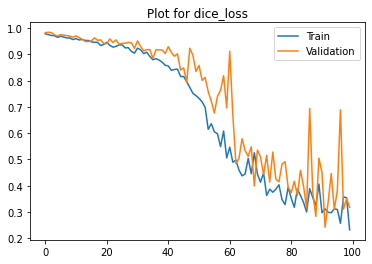

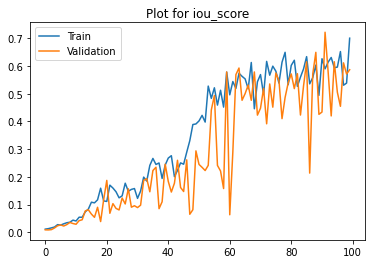

In [28]:
plotter(train_logs_list,valid_logs_list,params)

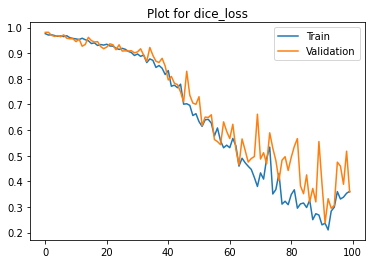

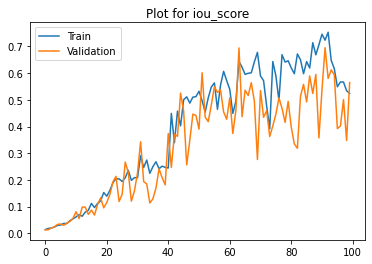

In [21]:
plotter(train_logs_list,valid_logs_list,params)

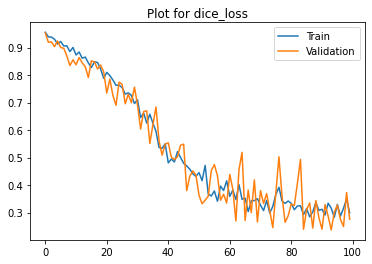

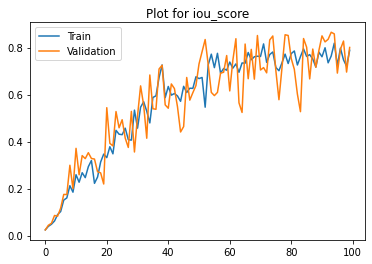

In [35]:
plotter(train_logs_list,valid_logs_list,params)

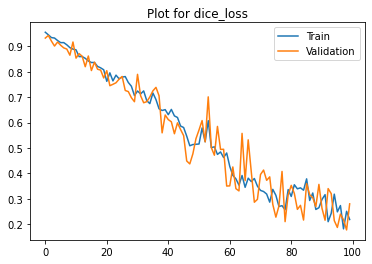

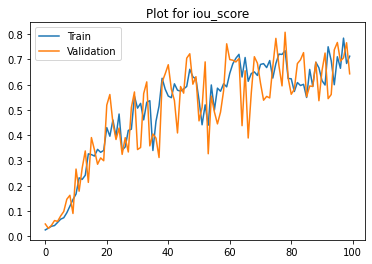

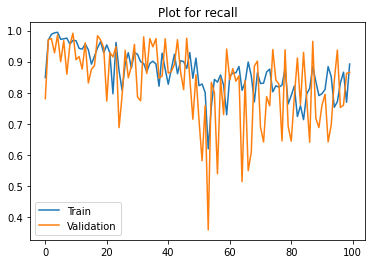

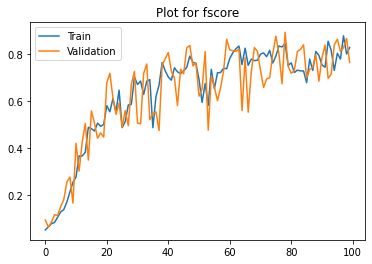

In [21]:
# 50 no sheduler
plotter(train_logs_list,valid_logs_list,params)

## Evaluate

In [22]:
EVALUATE_EPOCHS = 10

In [23]:
best_iou_score = 0.0
test_logs_list = []

for i in range(0, EVALUATE_EPOCHS):

    # Perform training & validation
    print('\nEpoch: {}'.format(i))
    test_logs = valid_epoch.run(valid_loader)
    test_logs_list.append(test_logs)

    # Save model if a better val IoU score is obtained
    if best_iou_score < test_logs['iou_score']:
        best_iou_score = test_logs['iou_score']



print(f'------------\nValidation scores:\n {list_dict_mean(test_logs_list)}\n------------')


Epoch: 0
valid: 100%|███| 3/3 [00:00<00:00,  5.67it/s, dice_loss - 0.3589, iou_score - 0.5546, recall - 0.7034, fscore - 0.6829]

Epoch: 1
valid: 100%|███| 3/3 [00:00<00:00,  9.96it/s, dice_loss - 0.1914, iou_score - 0.7372, recall - 0.8818, fscore - 0.8486]

Epoch: 2
valid: 100%|███| 3/3 [00:00<00:00,  9.56it/s, dice_loss - 0.2752, iou_score - 0.6032, recall - 0.8574, fscore - 0.7516]

Epoch: 3
valid: 100%|████| 3/3 [00:00<00:00,  9.28it/s, dice_loss - 0.264, iou_score - 0.6233, recall - 0.8022, fscore - 0.7631]

Epoch: 4
valid: 100%|███| 3/3 [00:00<00:00,  9.83it/s, dice_loss - 0.2322, iou_score - 0.6761, recall - 0.8736, fscore - 0.8029]

Epoch: 5
valid: 100%|████| 3/3 [00:00<00:00, 10.21it/s, dice_loss - 0.2141, iou_score - 0.729, recall - 0.8533, fscore - 0.8418]

Epoch: 6
valid: 100%|███| 3/3 [00:00<00:00, 10.09it/s, dice_loss - 0.1983, iou_score - 0.7427, recall - 0.8703, fscore - 0.8492]

Epoch: 7
valid: 100%|████| 3/3 [00:00<00:00, 10.06it/s, dice_loss - 0.226, iou_score - 0.

## Loading best model

In [68]:
l_model = torch.load(os.path.join(dataset_dir,model_save_name))

## Looking at results

In [17]:
def show_tensor_image(tensor):
    cpu = tensor.cpu()
    images = cpu[0].permute(1, 2, 0)
    
    im_num = images.shape[2]
    
    fig, axs = plt.subplots(1,im_num)
    
    if im_num == 1:
        axs.imshow(images[:,:])
    else:
        for ch in range(im_num):
            axs[ch].imshow(images[:,:,ch])

In [31]:
valid_iter = iter(valid_loader)

In [32]:
test_input,test_lable = next(valid_iter)
test_input = test_input.cuda()

In [33]:
test_pred = model.predict(test_input)

### Predict with best model

In [69]:
test_pred = l_model.predict(test_input)

### All aorta images

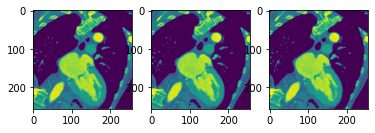

In [ ]:
show_tensor_image(test_input)

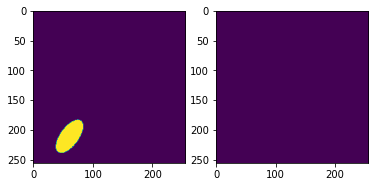

In [ ]:
show_tensor_image(test_lable)

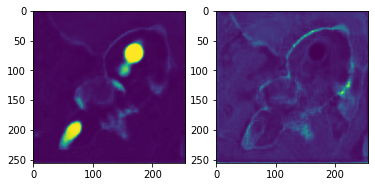

In [ ]:
show_tensor_image(test_pred)

### Only top images

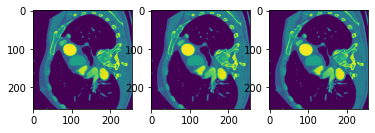

In [75]:
show_tensor_image(test_input)

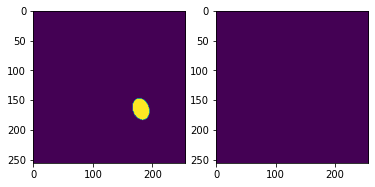

In [76]:
show_tensor_image(test_lable)

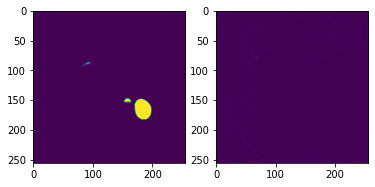

In [77]:
show_tensor_image(test_pred)

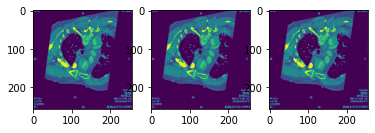

In [72]:
show_tensor_image(test_input)

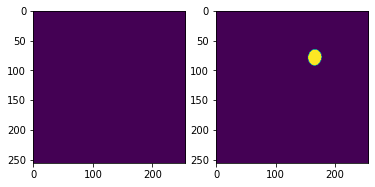

In [73]:
show_tensor_image(test_lable)

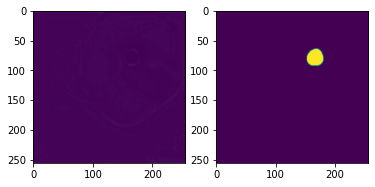

In [74]:
show_tensor_image(test_pred)

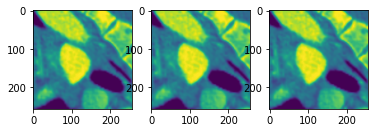

In [65]:
show_tensor_image(test_input)

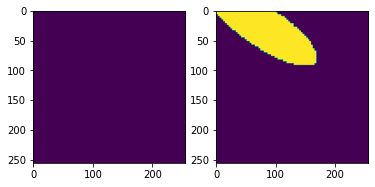

In [66]:
show_tensor_image(test_lable)

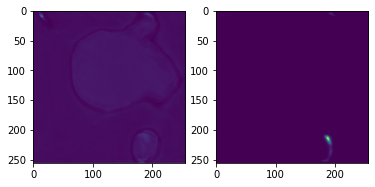

In [67]:
show_tensor_image(test_pred)

Для отчёта

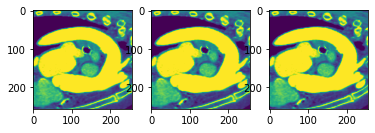

In [21]:
show_tensor_image(test_input)

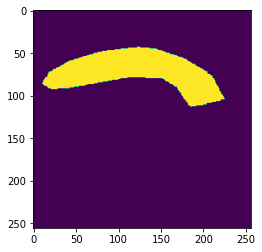

In [22]:
show_tensor_image(test_lable)

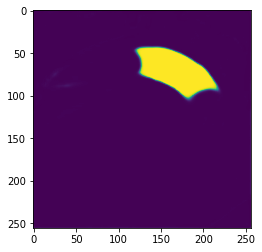

In [23]:
show_tensor_image(test_pred)

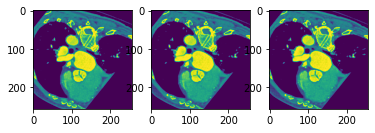

In [34]:
show_tensor_image(test_input)

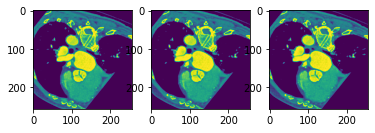

In [38]:
cpu = test_input.cpu()
images = cpu[0].permute(1, 2, 0)

im_num = images.shape[2]

fig, axs = plt.subplots(1,im_num)

if im_num == 1:
    axs.imshow(images[:,:])
else:
    for ch in range(im_num):
        axs[ch].imshow(images[:,:,ch])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 255.5, 255.5, -0.5)

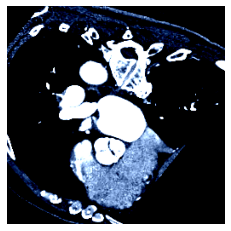

In [43]:
plt.imshow(images)
plt.axis('off')

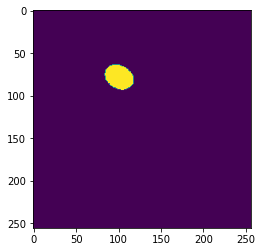

In [35]:
show_tensor_image(test_lable)

In [44]:
cpu = test_lable.cpu()
images = cpu[0].permute(1, 2, 0)

(-0.5, 255.5, 255.5, -0.5)

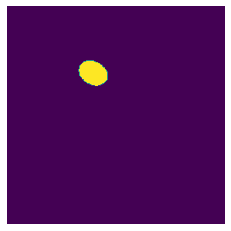

In [45]:
plt.imshow(images)
plt.axis('off')


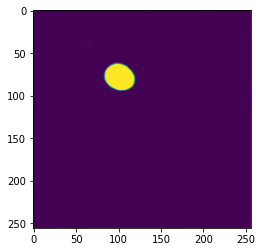

In [36]:
show_tensor_image(test_pred)

(-0.5, 255.5, 255.5, -0.5)

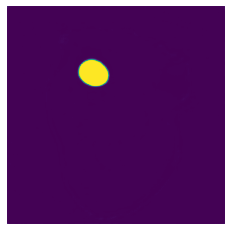

In [48]:
cpu = test_pred.cpu()
images = cpu[0].permute(1, 2, 0)
plt.imshow(images)
plt.axis('off')

# Saved Results

## Descending only, ResNet50, Lr_shed = ReduceLROnPlateau

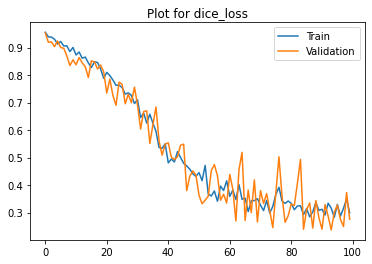

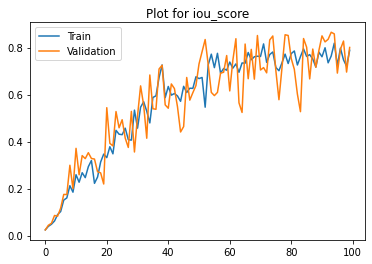

In [35]:
plotter(train_logs_list,valid_logs_list,params)

In [37]:
best_iou_score = 0.0
test_logs_list = []

for i in range(0, EVALUATE_EPOCHS):

    # Perform training & validation
    print('\nEpoch: {}'.format(i))
    test_logs = valid_epoch.run(valid_loader)
    test_logs_list.append(test_logs)

    # Save model if a better val IoU score is obtained
    if best_iou_score < test_logs['iou_score']:
        best_iou_score = test_logs['iou_score']



print(f'------------\nValidation scores:\n {list_dict_mean(test_logs_list)}\n------------')


Epoch: 0
valid: 100%|█████████████████████████████████████| 4/4 [00:00<00:00,  5.98it/s, dice_loss - 0.3214, iou_score - 0.7412]

Epoch: 1
valid: 100%|█████████████████████████████████████| 4/4 [00:00<00:00,  7.54it/s, dice_loss - 0.2638, iou_score - 0.7738]

Epoch: 2
valid: 100%|█████████████████████████████████████| 4/4 [00:00<00:00,  7.34it/s, dice_loss - 0.3572, iou_score - 0.6927]

Epoch: 3
valid: 100%|█████████████████████████████████████| 4/4 [00:00<00:00,  7.67it/s, dice_loss - 0.3115, iou_score - 0.7033]

Epoch: 4
valid: 100%|█████████████████████████████████████| 4/4 [00:00<00:00,  7.55it/s, dice_loss - 0.3719, iou_score - 0.7698]

Epoch: 5
valid: 100%|█████████████████████████████████████| 4/4 [00:00<00:00,  7.40it/s, dice_loss - 0.3468, iou_score - 0.6938]

Epoch: 6
valid: 100%|██████████████████████████████████████| 4/4 [00:00<00:00,  7.46it/s, dice_loss - 0.381, iou_score - 0.6397]

Epoch: 7
valid: 100%|█████████████████████████████████████| 4/4 [00:00<00:00,  7.18it/s, 

## Descending only, ResNet101, Lr_shed = ReduceLROnPlateau

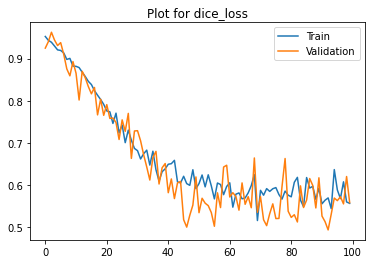

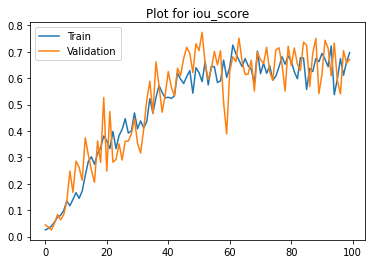

In [22]:
# 101 plateu
plotter(train_logs_list,valid_logs_list,params)

In [26]:
best_iou_score = 0.0
test_logs_list = []

for i in range(0, EVALUATE_EPOCHS):

    # Perform training & validation
    print('\nEpoch: {}'.format(i))
    test_logs = valid_epoch.run(valid_loader)
    test_logs_list.append(test_logs)

    # Save model if a better val IoU score is obtained
    if best_iou_score < test_logs['iou_score']:
        best_iou_score = test_logs['iou_score']



print(f'------------\nValidation scores:\n {list_dict_mean(test_logs_list)}\n------------')


Epoch: 0
valid: 100%|█████████████████████████████████████| 4/4 [00:00<00:00,  5.01it/s, dice_loss - 0.5497, iou_score - 0.7157]

Epoch: 1
valid: 100%|█████████████████████████████████████| 4/4 [00:00<00:00,  6.35it/s, dice_loss - 0.5749, iou_score - 0.7003]

Epoch: 2
valid: 100%|█████████████████████████████████████| 4/4 [00:00<00:00,  6.25it/s, dice_loss - 0.5011, iou_score - 0.6938]

Epoch: 3
valid: 100%|█████████████████████████████████████| 4/4 [00:00<00:00,  6.40it/s, dice_loss - 0.5492, iou_score - 0.6288]

Epoch: 4
valid: 100%|█████████████████████████████████████| 4/4 [00:00<00:00,  6.30it/s, dice_loss - 0.5644, iou_score - 0.7242]

Epoch: 5
valid: 100%|█████████████████████████████████████| 4/4 [00:00<00:00,  6.33it/s, dice_loss - 0.4966, iou_score - 0.7806]

Epoch: 6
valid: 100%|█████████████████████████████████████| 4/4 [00:00<00:00,  6.49it/s, dice_loss - 0.4987, iou_score - 0.7618]

Epoch: 7
valid: 100%|███████████████████████████████████████| 4/4 [00:00<00:00,  6.63it/s